In [16]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import torchvision
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np

# Define the checkpoint path
CHECKPOINT_PATH = "/home/k54739/saved_models_simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)
        
        # Assuming the TIFF image has 3 layers
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Convert the 3 layers into a 3-channel grayscale image
        image = np.stack(image, axis=-1)
        image = Image.fromarray(image)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        else:
            image1 = image2 = transforms.ToTensor()(image)

        return (image1, image2), 0  # Returning a tuple to match the expected output format

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(pretrained=True)
        
        # Adjust input layer to accept 3 channels instead of 1
        self.convnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs).to(self.device)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')


# Function to train the model
def train_simclr(batch_size, max_epochs=50, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=50)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.019    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/PIL/Image.py", line 3277, in fromarray
    mode, rawmode = _fromarray_typemap[typekey]
                    ~~~~~~~~~~~~~~~~~~^^^^^^^^^
KeyError: ((1, 1, 3), '<u2')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2598155/3820899588.py", line 39, in __getitem__
    image = Image.fromarray(image)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/PIL/Image.py", line 3281, in fromarray
    raise TypeError(msg) from e
TypeError: Cannot handle this data type: (1, 1, 3), <u2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.019    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 19/19 [00:27<00:00,  0.70it/s, v_num=6, train_loss_step=0.379, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=1.920, val_acc_top1=0.336, val_acc_top5=0.767, val_acc_mean_pos=3.640, train_loss_epoch=1.960, train_acc_top1_epoch=0.382, train_acc_top5_epoch=0.785, train_acc_mean_pos_epoch=3.770]  

`Trainer.fit` stopped: `max_epochs=50` reached.


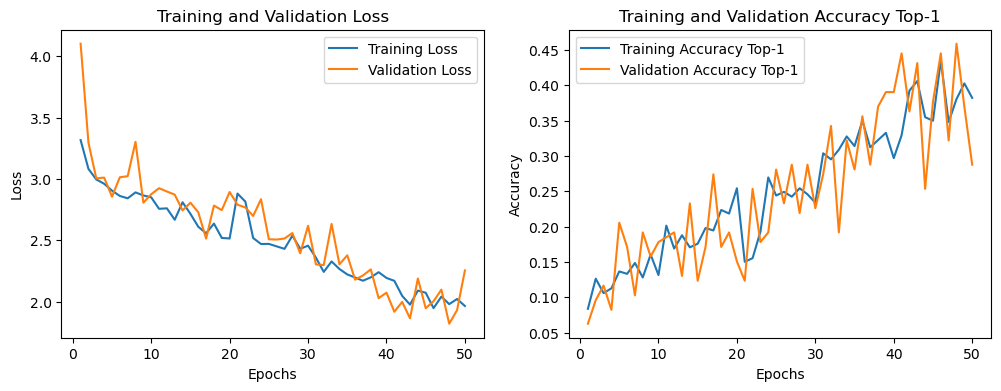

Epoch 49: 100%|██████████| 19/19 [00:27<00:00,  0.68it/s, v_num=6, train_loss_step=0.379, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=1.920, val_acc_top1=0.336, val_acc_top5=0.767, val_acc_mean_pos=3.640, train_loss_epoch=1.960, train_acc_top1_epoch=0.382, train_acc_top5_epoch=0.785, train_acc_mean_pos_epoch=3.770]


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import torchvision
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np

# Define the checkpoint path
CHECKPOINT_PATH = "./saved_models/simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)
        
        # Assuming the TIFF image has 3 layers
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit grayscale image layers to 8-bit
        image_min = image.min(axis=(1, 2), keepdims=True)
        image_max = image.max(axis=(1, 2), keepdims=True)
        image = (image - image_min) / (image_max - image_min + 1e-7)  # Normalize to [0, 1]
        image = (image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to 8-bit
        
        # Convert the 3 layers into a 3-channel image
        image = np.stack(image, axis=-1)
        image = Image.fromarray(image)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        else:
            image1 = image2 = transforms.ToTensor()(image)

        return (image1, image2), 0  # Returning a tuple to match the expected output format

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(pretrained=True)
        
        # Adjust input layer to accept 3 channels instead of 1
        self.convnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll, on_epoch=True, prog_bar=True)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')



# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())

    def on_train_end(self, trainer, pl_module):
        # Ensure the lists are the same length
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_acc_top1), len(self.val_acc_top1))
        self.train_losses = self.train_losses[:min_len]
        self.val_losses = self.val_losses[:min_len]
        self.train_acc_top1 = self.train_acc_top1[:min_len]
        self.val_acc_top1 = self.val_acc_top1[:min_len]

        # Plotting the loss curves
        epochs = range(1, min_len + 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plotting the accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_acc_top1, label='Training Accuracy Top-1')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy Top-1')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-1')

        plt.show()


# Function to train the model
def train_simclr(batch_size, max_epochs=2, **kwargs):
    plot_callback = PlotLossAccuracyCallback()
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])
    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=50)




In [ ]:
#20 minutes

In [ ]:
%load_ext tensorboard


In [ ]:
!kill 2584979

In [ ]:
# Start TensorBoard
%tensorboard --logdir ./saved_models/simclr/SimCLR/lightning_logs/

Reusing TensorBoard on port 6008 (pid 2600148), started 0:02:55 ago. (Use '!kill 2600148' to kill it.)

In [ ]:
import os

# List files in the tensorboard log directory
log_dir = "./saved_models/simclr/SimCLR/lightning_logs/"
os.listdir(log_dir)


['version_1', 'version_0', 'version_2']

In [7]:
import matplotlib.pyplot as plt

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import tifffile as tiff

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)
        
        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        print('yes1',image.shape)
        
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0  # Normalize to [0, 1]
        print('yes2',image.shape)
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        # Permute dimensions to (C, H, W) as expected by PyTorch
        #image = image.permute(1, 2, 0)  # (H, W, C) to (C, H, W)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        else:
            image1 = image2 = transforms.ToTensor()(image)

        return (image1, image2) # Returning a tuple to match the expected output format

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 1

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Check an example to ensure correct conversion
for (img1, img2) in train_loader:
    print(img1.shape, img1.dtype)
    break


yes1yes1yes1  yes1 yes1(3, 2054, 2456) (3, 2054, 2456)
(3, 2054, 2456)yes1yes1 (3, 2054, 2456)(3, 2054, 2456)
 yes1yes1yes1
  
 yes1 (3, 2054, 2456)yes1 yes1(3, 2054, 2456)
 (3, 2054, 2456)(3, 2054, 2456)(3, 2054, 2456) (3, 2054, 2456)yes1yes1


(3, 2054, 2456)

 (3, 2054, 2456)

(3, 2054, 2456) 
yes1yes1yes1
yes1(3, 2054, 2456) yes1  (3, 2054, 2456) 
 (3, 2054, 2456)(3, 2054, 2456)(3, 2054, 2456)yes1(3, 2054, 2456)

yes1
yes1yes2yes1
yes2  
yes2yes2  (3, 2054, 2456) (3, 2054, 2456)yes1(3, 2054, 2456) (3, 2054, 2456)yes2  (3, 2054, 2456)yes1


 (3, 2054, 2456) yes2(3, 2054, 2456)(3, 2054, 2456)(3, 2054, 2456)
 yes2yes1
yes1
(3, 2054, 2456)yes2yes1yes1yes1 

yes2 
  yes2 yes2 
(3, 2054, 2456)yes2(3, 2054, 2456)  yes2(3, 2054, 2456) (3, 2054, 2456)(3, 2054, 2456)yes1(3, 2054, 2456)(3, 2054, 2456) 
(3, 2054, 2456)(3, 2054, 2456)(3, 2054, 2456) 


 


yes2 (3, 2054, 2456)(3, 2054, 2456)
 yes2
(3, 2054, 2456) yes2(3, 2054, 2456)

yes2(3, 2054, 2456)yes2 
(3, 2054, 2456)
yes2 yes2 (3, 2054, 

tensor([[[[32043.5977, 32054.6523, 32074.4785,  ..., 31296.7246,
           31233.2734, 31206.6484],
          [32044.7383, 32055.8867, 32075.9785,  ..., 31309.2715,
           31250.8281, 31226.4141],
          [32046.3945, 32057.2773, 32077.6426,  ..., 31346.8887,
           31300.6543, 31281.5625],
          ...,
          [32363.7090, 32370.4277, 32382.3574,  ..., 32391.1621,
           32399.0059, 32400.1152],
          [32353.2324, 32359.1230, 32368.6621,  ..., 32377.9199,
           32394.3652, 32398.6074],
          [32349.3262, 32354.9590, 32363.6699,  ..., 32372.3418,
           32392.6621, 32398.2949]],

         [[32033.5586, 32046.8242, 32071.3926,  ..., 31231.1406,
           31180.0391, 31159.5254],
          [32028.5742, 32041.2461, 32065.0254,  ..., 31246.2969,
           31199.6875, 31180.9922],
          [32017.5898, 32028.1914, 32049.4648,  ..., 31289.9297,
           31253.4922, 31238.7188],
          ...,
          [32319.3594, 32328.7637, 32345.7168,  ..., 32388.

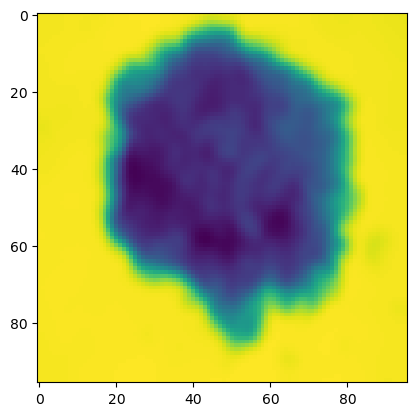

In [10]:
print(img1*65535.0)
plt.imshow(img1[0,0]*65535.0)


In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import tifffile as tiff

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)
        
        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        print('yes1',image.shape)
        
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0  # Normalize to [0, 1]
        print('yes2',image.shape)
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        # Permute dimensions to (C, H, W) as expected by PyTorch
        #image = image.permute(1, 2, 0)  # (H, W, C) to (C, H, W)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        else:
            image1 = image2 = transforms.ToTensor()(image)

        return (image1, image2) # Returning a tuple to match the expected output format

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 1

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Check an example to ensure correct conversion
for (img1, img2) in train_loader:
    print(img1.shape, img1.dtype)
    break

yes1 yes1(3, 2054, 2456)yes1 yes1
(3, 2054, 2456)yes1
 (3, 2054, 2456)  (3, 2054, 2456)(3, 2054, 2456)
yes1yes1yes1yes1
 
yes1(3, 2054, 2456)yes2    (3, 2054, 2456)(3, 2054, 2456)
 yes1

(3, 2054, 2456)(3, 2054, 2456) (3, 2054, 2456)
yes1
(3, 2054, 2456)yes1
yes2  yes1(3, 2054, 2456)yes2 
 (3, 2054, 2456)yes2(3, 2054, 2456)(3, 2054, 2456) yes1yes1(3, 2054, 2456) yes1


yes1(3, 2054, 2456) yes1

yes1  (3, 2054, 2456)
yes1yes2(3, 2054, 2456) (3, 2054, 2456) yes1   

yes1yes1 (3, 2054, 2456)(3, 2054, 2456)yes1yes1(3, 2054, 2456)
(3, 2054, 2456) yes2
yes2
(3, 2054, 2456)  (3, 2054, 2456)(3, 2054, 2456)
(3, 2054, 2456)yes1 yes2yes1
 yes2
 (3, 2054, 2456) 
  (3, 2054, 2456)(3, 2054, 2456)


(3, 2054, 2456)(3, 2054, 2456)(3, 2054, 2456) yes2


(3, 2054, 2456) yes1
(3, 2054, 2456)

(3, 2054, 2456)yes1

  (3, 2054, 2456)yes1(3, 2054, 2456)
yes2
yes2 yes2yes1 (3, 2054, 2456) yes2(3, 2054, 2456)yes1yes2
 yes2yes2yes2 (3, 2054, 2456)(3, 2054, 2456) yes2
  
 
  (3, 2054, 2456) (3, 2054, 2456)(3, 20

In [ ]:
#only divide by 65535.0

torch.Size([16, 3, 96, 96]) torch.float32


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.019    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 19/19 [00:21<00:00,  0.87it/s, v_num=13, train_loss_step=1.580, train_acc_top1_step=0.400, train_acc_top5_step=1.000, train_acc_mean_pos_step=2.300, val_loss=2.790, val_acc_top1=0.123, val_acc_top5=0.500, val_acc_mean_pos=7.340, train_loss_epoch=2.910, train_acc_top1_epoch=0.113, train_acc_top5_epoch=0.430, train_acc_mean_pos_epoch=8.260]  

`Trainer.fit` stopped: `max_epochs=5` reached.


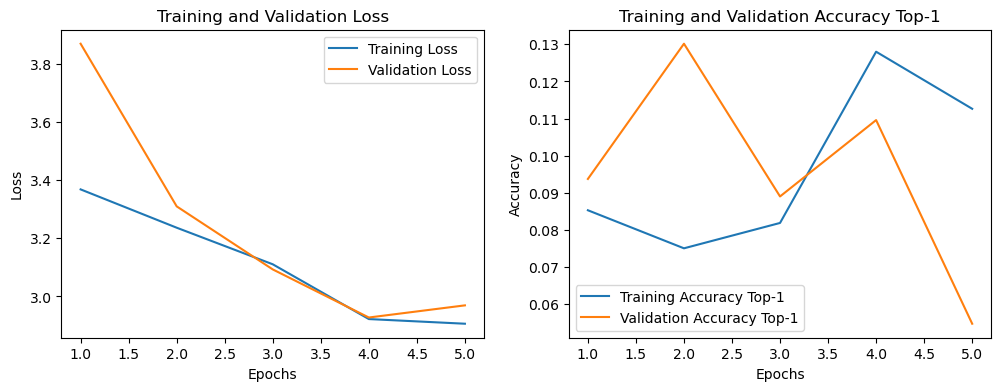

Epoch 4: 100%|██████████| 19/19 [00:22<00:00,  0.83it/s, v_num=13, train_loss_step=1.580, train_acc_top1_step=0.400, train_acc_top5_step=1.000, train_acc_mean_pos_step=2.300, val_loss=2.790, val_acc_top1=0.123, val_acc_top5=0.500, val_acc_mean_pos=7.340, train_loss_epoch=2.910, train_acc_top1_epoch=0.113, train_acc_top5_epoch=0.430, train_acc_mean_pos_epoch=8.260]


In [7]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import tifffile as tiff
import matplotlib.pyplot as plt

CHECKPOINT_PATH = "./saved_models/simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)
        
        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        else:
            image1 = image2 = transforms.ToTensor()(image)

        return image1, image2



# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Check an example to ensure correct conversion
for (img1, img2) in train_loader:
    print(img1.shape, img1.dtype)
    break

# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(pretrained=True)
        
        # Adjust input layer to accept 3 channels instead of 1
        self.convnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs1, imgs2 = batch
        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + '_loss', nll, on_epoch=True, prog_bar=True)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + '_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_mean_pos', 1 + sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')



# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())

    def on_train_end(self, trainer, pl_module):
        # Ensure the lists are the same length
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_acc_top1), len(self.val_acc_top1))
        self.train_losses = self.train_losses[:min_len]
        self.val_losses = self.val_losses[:min_len]
        self.train_acc_top1 = self.train_acc_top1[:min_len]
        self.val_acc_top1 = self.val_acc_top1[:min_len]

        # Plotting the loss curves
        epochs = range(1, min_len + 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plotting the accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_acc_top1, label='Training Accuracy Top-1')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy Top-1')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-1')

        plt.show()


# Function to train the model
def train_simclr(batch_size, max_epochs=50, **kwargs):
    plot_callback = PlotLossAccuracyCallback()
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])
    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=5)


In [ ]:
def add_contrastive_loss(hidden, hidden_norm=True, temperature=1.0, weights=1.0):
    if hidden_norm:
        hidden = tf.math.l2_normalize(hidden, -1)
    hidden1, hidden2 = tf.split(hidden, 2, 0)
    batch_size = tf.shape(hidden1)[0]

    logits_aa = tf.matmul(hidden1, hidden1, transpose_b=True) / temperature
    logits_bb = tf.matmul(hidden2, hidden2, transpose_b=True) / temperature
    logits_ab = tf.matmul(hidden1, hidden2, transpose_b=True) / temperature
    logits_ba = tf.matmul(hidden2, hidden1, transpose_b=True) / temperature

    labels = tf.one_hot(tf.range(batch_size), batch_size * 2)
    masks = tf.one_hot(tf.range(batch_size), batch_size)

    logits_aa -= masks * 1e9
    logits_bb -= masks * 1e9

    loss_a = tf.losses.softmax_cross_entropy(labels, tf.concat([logits_ab, logits_aa], 1), weights=weights)
    loss_b = tf.losses.softmax_cross_entropy(labels, tf.concat([logits_ba, logits_bb], 1), weights=weights)
    loss = loss_a + loss_b

    return loss

torch.Size([16, 3, 96, 96]) torch.float32


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
---------------------------------

Epoch 49: 100%|██████████| 19/19 [00:21<00:00,  0.88it/s, v_num=14, train_loss_step=0.360, train_acc_top1_step=0.800, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.200, val_loss=2.130, val_acc_top1=0.260, val_acc_top5=0.747, val_acc_mean_pos=4.210, train_loss_epoch=2.120, train_acc_top1_epoch=0.343, train_acc_top5_epoch=0.761, train_acc_mean_pos_epoch=3.970]  

`Trainer.fit` stopped: `max_epochs=50` reached.


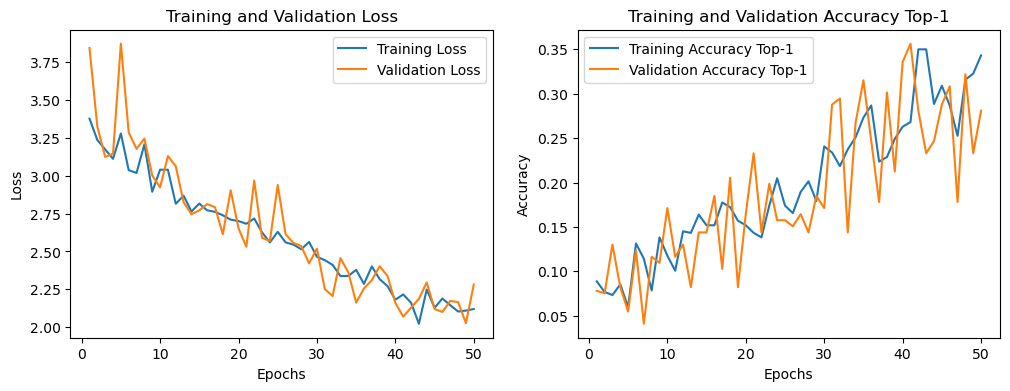

Epoch 49: 100%|██████████| 19/19 [00:22<00:00,  0.85it/s, v_num=14, train_loss_step=0.360, train_acc_top1_step=0.800, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.200, val_loss=2.130, val_acc_top1=0.260, val_acc_top5=0.747, val_acc_mean_pos=4.210, train_loss_epoch=2.120, train_acc_top1_epoch=0.343, train_acc_top5_epoch=0.761, train_acc_mean_pos_epoch=3.970]


/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import tifffile as tiff
import matplotlib.pyplot as plt

CHECKPOINT_PATH = "./saved_models/simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)
        
        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        else:
            image1 = image2 = transforms.ToTensor()(image)

        return image1, image2



# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Check an example to ensure correct conversion
for (img1, img2) in train_loader:
    print(img1.shape, img1.dtype)
    break

# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(pretrained=True)
        
        # Adjust input layer to accept 3 channels instead of 1
        self.convnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs1, imgs2 = batch
        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + '_loss', nll, on_epoch=True, prog_bar=True)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + '_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_mean_pos', 1 + sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')



# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())

    def on_train_end(self, trainer, pl_module):
        # Ensure the lists are the same length
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_acc_top1), len(self.val_acc_top1))
        self.train_losses = self.train_losses[:min_len]
        self.val_losses = self.val_losses[:min_len]
        self.train_acc_top1 = self.train_acc_top1[:min_len]
        self.val_acc_top1 = self.val_acc_top1[:min_len]

        # Plotting the loss curves
        epochs = range(1, min_len + 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plotting the accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_acc_top1, label='Training Accuracy Top-1')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy Top-1')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-1')

        plt.show()


# Function to train the model
def train_simclr(batch_size, max_epochs=50, **kwargs):
    plot_callback = PlotLossAccuracyCallback()
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])
    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=50)


torch.Size([16, 3, 96, 96]) torch.float32


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
---------------------------------

Epoch 4: 100%|██████████| 19/19 [00:18<00:00,  1.01it/s, v_num=21, train_loss_step=1.440, train_acc_top1_step=0.400, train_acc_top5_step=1.000, train_acc_mean_pos_step=2.200, val_loss=2.470, val_acc_top1=0.260, val_acc_top5=0.603, val_acc_mean_pos=5.460, train_loss_epoch=2.540, train_acc_top1_epoch=0.203, train_acc_top5_epoch=0.584, train_acc_mean_pos_epoch=5.770] 

`Trainer.fit` stopped: `max_epochs=5` reached.


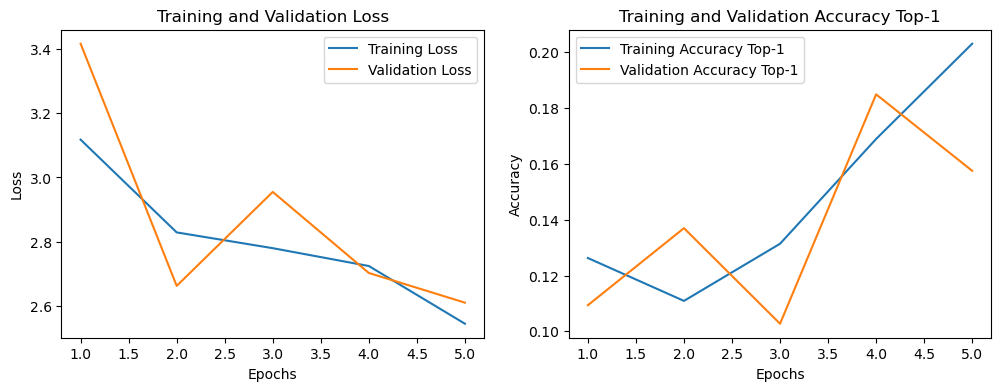

Epoch 4: 100%|██████████| 19/19 [00:20<00:00,  0.94it/s, v_num=21, train_loss_step=1.440, train_acc_top1_step=0.400, train_acc_top5_step=1.000, train_acc_mean_pos_step=2.200, val_loss=2.470, val_acc_top1=0.260, val_acc_top5=0.603, val_acc_mean_pos=5.460, train_loss_epoch=2.540, train_acc_top1_epoch=0.203, train_acc_top5_epoch=0.584, train_acc_mean_pos_epoch=5.770]


/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [3]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import tifffile as tiff
import matplotlib.pyplot as plt

CHECKPOINT_PATH = "./saved_models/simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)
        
        
        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        else:
            image1 = image2 = transforms.ToTensor()(image)

        return image1, image2



# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Check an example to ensure correct conversion
for (img1, img2) in train_loader:
    print(img1.shape, img1.dtype)
    break

# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(pretrained=True)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs1, imgs2 = batch
        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + '_loss', nll, on_epoch=True, prog_bar=True)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + '_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_mean_pos', 1 + sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')



# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())

    def on_train_end(self, trainer, pl_module):
        # Ensure the lists are the same length
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_acc_top1), len(self.val_acc_top1))
        self.train_losses = self.train_losses[:min_len]
        self.val_losses = self.val_losses[:min_len]
        self.train_acc_top1 = self.train_acc_top1[:min_len]
        self.val_acc_top1 = self.val_acc_top1[:min_len]

        # Plotting the loss curves
        epochs = range(1, min_len + 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plotting the accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_acc_top1, label='Training Accuracy Top-1')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy Top-1')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-1')

        plt.show()


# Function to train the model
def train_simclr(batch_size, max_epochs=50, **kwargs):
    plot_callback = PlotLossAccuracyCallback()
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])
    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=5)


Positive mask correction 

torch.Size([16, 3, 96, 96]) torch.float32


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
---------------------------------

Epoch 4: 100%|██████████| 19/19 [00:20<00:00,  0.95it/s, v_num=29, train_loss_step=2.170, train_acc_top1_step=0.200, train_acc_top5_step=0.800, train_acc_mean_pos_step=3.900, val_loss=3.360, val_acc_top1=0.000, val_acc_top5=0.185, val_acc_mean_pos=14.50, train_loss_epoch=3.420, train_acc_top1_epoch=0.0188, train_acc_top5_epoch=0.147, train_acc_mean_pos_epoch=16.00]   

`Trainer.fit` stopped: `max_epochs=5` reached.


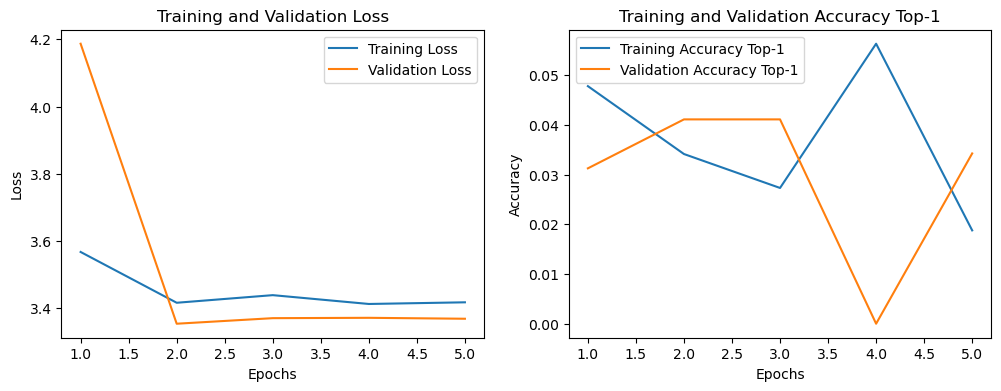

Epoch 4: 100%|██████████| 19/19 [00:20<00:00,  0.91it/s, v_num=29, train_loss_step=2.170, train_acc_top1_step=0.200, train_acc_top5_step=0.800, train_acc_mean_pos_step=3.900, val_loss=3.360, val_acc_top1=0.000, val_acc_top5=0.185, val_acc_mean_pos=14.50, train_loss_epoch=3.420, train_acc_top1_epoch=0.0188, train_acc_top5_epoch=0.147, train_acc_mean_pos_epoch=16.00]


/home/k54739/miniconda3/envs/thesis/lib/python3.12/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import tifffile as tiff
import matplotlib.pyplot as plt

CHECKPOINT_PATH = "./saved_models/simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)
        
        
        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        else:
            image1 = image2 = transforms.ToTensor()(image)

        return image1, image2



# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Check an example to ensure correct conversion
for (img1, img2) in train_loader:
    print(img1.shape, img1.dtype)
    break

# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(pretrained=True)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs1, imgs2 = batch
        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        
        # Create target tensor
        target = torch.arange(cos_sim.shape[0], device=cos_sim.device)
        target[0::2] += 1
        target[1::2] -= 1
        index = target.reshape(cos_sim.shape[0], 1).long()

        # Prepare ground_truth_labels
        ground_truth_labels = torch.zeros(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        src = torch.ones(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        ground_truth_labels = torch.scatter(ground_truth_labels, 1, index, src)
        pos_mask = ground_truth_labels.bool()
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + '_loss', nll, on_epoch=True, prog_bar=True)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + '_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_mean_pos', 1 + sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')



# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())

    def on_train_end(self, trainer, pl_module):
        # Ensure the lists are the same length
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_acc_top1), len(self.val_acc_top1))
        self.train_losses = self.train_losses[:min_len]
        self.val_losses = self.val_losses[:min_len]
        self.train_acc_top1 = self.train_acc_top1[:min_len]
        self.val_acc_top1 = self.val_acc_top1[:min_len]

        # Plotting the loss curves
        epochs = range(1, min_len + 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plotting the accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_acc_top1, label='Training Accuracy Top-1')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy Top-1')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-1')

        plt.show()


# Function to train the model
def train_simclr(batch_size, max_epochs=50, **kwargs):
    plot_callback = PlotLossAccuracyCallback()
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])
    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=5)


Cleaned without pytorch lightning

In [ ]:
weights='ResNet18_Weights.DEFAULT'

In [11]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        else:
            image1 = image2 = transforms.ToTensor()(image)

        return image1, image2

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Define the SimCLR model class (plain PyTorch version)
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):
        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        
        # Create target tensor
        target = torch.arange(cos_sim.shape[0], device=cos_sim.device)
        target[0::2] += 1
        target[1::2] -= 1
        index = target.reshape(cos_sim.shape[0], 1).long()

        # Prepare ground_truth_labels
        ground_truth_labels = torch.zeros(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        src = torch.ones(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        ground_truth_labels = torch.scatter(ground_truth_labels, 1, index, src)
        pos_mask = ground_truth_labels.bool()
        # InfoNCE loss
        cos_sim = cos_sim / self.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        return nll

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        for batch in train_loader:
            imgs1, imgs2 = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
            self.optimizer.zero_grad()
            loss = self.info_nce_loss(imgs1, imgs2, device)
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                imgs1, imgs2 = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
                loss = self.info_nce_loss(imgs1, imgs2, device)
                total_loss += loss.item()
        return total_loss / len(val_loader)

# Function to train the model
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    # Determine the device to use
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the model and move it to the device
    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    for epoch in range(max_epochs):
        train_loss = model.train_epoch(train_loader, device)
        val_loss = model.validate_epoch(val_loader, device)
        print(f"Epoch {epoch+1}/{max_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

# Run the training script
train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=2)

Using device: cuda
Epoch 1/2
Train Loss: 3.5112
Validation Loss: 3.3295
Epoch 2/2
Train Loss: 3.3998
Validation Loss: 3.3226


In [2]:
import numpy as np
import torch
from tifffile import imread

# Load the image
img_path = '/home/k54739/.tiff_experiment_unsupervised_data/combined/1.tiff'
image = imread(img_path)

# Ensure the image has 3 layers (channels)
if image.shape[0] != 3:
    raise ValueError(f"Image {img_path} does not have exactly 3 layers. It has {image.shape[0]} layers.")

# Convert the image to float32
image = image.astype(np.float32)

# Check if the layers are repeating
layer1 = image[0]
layer2 = image[1]
layer3 = image[2]

if np.array_equal(layer1, layer2) and np.array_equal(layer1, layer3):
    print("All three layers are identical.")
elif np.array_equal(layer1, layer2):
    print("Layer 1 and Layer 2 are identical.")
elif np.array_equal(layer1, layer3):
    print("Layer 1 and Layer 3 are identical.")
elif np.array_equal(layer2, layer3):
    print("Layer 2 and Layer 3 are identical.")
else:
    print("All three layers are unique.")

All three layers are unique.


In [7]:
import numpy as np
import torch
from tifffile import imread

# Load the image
img_path = '/home/k54739/.tiff_experiment_unsupervised_data/combined/1.tiff'
image = imread(img_path)

# Ensure the image has 3 layers (channels)
if image.shape[0] != 3:
    raise ValueError(f"Image {img_path} does not have exactly 3 layers. It has {image.shape[0]} layers.")

# Initialize list to store sharpness of each layer
list_sharpness = []

# Calculate sharpness for each layer
for i in range(3):
    layer = image[i]
    gy, gx = np.gradient(layer)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(gnorm)
    list_sharpness.append(sharpness)

# Find the index of the sharpest layer
sharpest_layer_index = np.argmax(list_sharpness)
print(f"The sharpest layer is layer {sharpest_layer_index + 1} with sharpness {list_sharpness[sharpest_layer_index]}")

# Extract the sharpest layer
sharpest_layer = image[sharpest_layer_index]


# Optionally, convert the sharpest layer to a tensor (if needed for further processing)
sharpest_layer_tensor = torch.tensor(sharpest_layer, dtype=torch.float32)



The sharpest layer is layer 1 with sharpness 471.44516434266546
(2054, 2456)
torch.Size([2054, 2456])


Sharpest layer = anchor , oters = Augs

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import tifffile as tiff
import matplotlib.pyplot as plt

In [3]:
CHECKPOINT_PATH = "./saved_models/simclr"  # Change this to your desired checkpoint path

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        self.resize_transform = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        aug1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        aug2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)
        aug1 = self.resize_transform(aug1)
        aug2 = self.resize_transform(aug2)

        return aug1, aug2

In [4]:
# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())



In [5]:
# Check an example to ensure correct conversion
for (aug1, aug2) in train_loader:
    print(aug1.shape, aug2.shape, aug1.dtype)
    break

torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256]) torch.float32


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
45.994    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 19/19 [00:36<00:00,  0.52it/s, v_num=36, train_loss_step=5.15e-6, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.0106, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.00227, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]

`Trainer.fit` stopped: `max_epochs=5` reached.


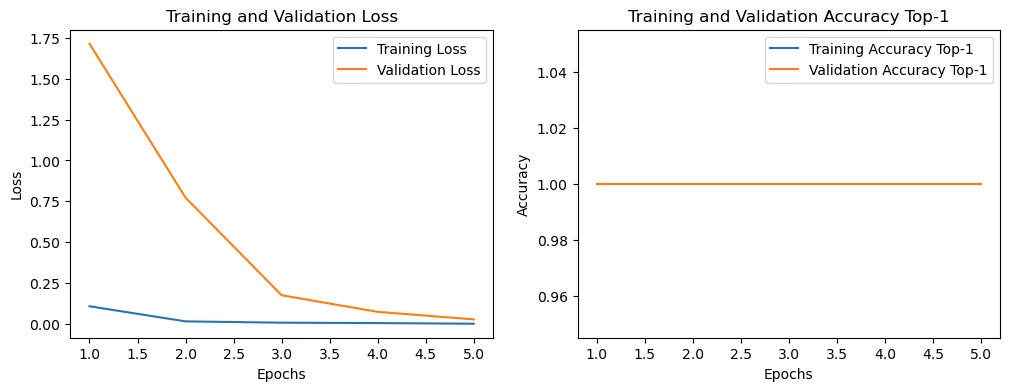

Epoch 4: 100%|██████████| 19/19 [00:37<00:00,  0.51it/s, v_num=36, train_loss_step=5.15e-6, train_acc_top1_step=1.000, train_acc_top5_step=1.000, train_acc_mean_pos_step=1.000, val_loss=0.0106, val_acc_top1=1.000, val_acc_top5=1.000, val_acc_mean_pos=1.000, train_loss_epoch=0.00227, train_acc_top1_epoch=1.000, train_acc_top5_epoch=1.000, train_acc_mean_pos_epoch=1.000]


In [7]:
# Define the SimCLR model class (same as in the tutorial)
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the first convolutional layer to accept single-channel input
        # Replace the existing convolutional layer with one that accepts a single channel
        #in_channels = 1
        '''self.convnet.conv1 = nn.Conv2d(in_channels, self.convnet.conv1.out_channels, 
                                        kernel_size=self.convnet.conv1.kernel_size, 
                                        stride=self.convnet.conv1.stride, 
                                        padding=self.convnet.conv1.padding, 
                                        bias=self.convnet.conv1.bias)'''
                                        
        weight = self.convnet.conv1.weight.clone()
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.convnet.conv1.weight.data = weight.sum(dim=1, keepdim=True)
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4*hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        aug1, aug2 = batch
        imgs = torch.cat((aug1, aug2), dim=0).to(self.device)  # Concatenate along the batch dimension

        # Encode all images
        feats = self.convnet(imgs).to(self.device)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + '_loss', nll, on_epoch=True, prog_bar=True)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode + '_acc_top1', (sim_argsort == 0).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_top5', (sim_argsort < 5).float().mean(), on_epoch=True, prog_bar=True)
        self.log(mode + '_acc_mean_pos', 1 + sim_argsort.float().mean(), on_epoch=True, prog_bar=True)

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')




# Define a callback to plot the training/validation loss and accuracy
class PlotLossAccuracyCallback(pl.Callback):
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc_top1 = []
        self.val_acc_top1 = []

    def on_train_epoch_end(self, trainer, pl_module):
        if 'train_loss' in trainer.callback_metrics:
            self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        if 'train_acc_top1' in trainer.callback_metrics:
            self.train_acc_top1.append(trainer.callback_metrics['train_acc_top1'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        if 'val_loss' in trainer.callback_metrics:
            self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        if 'val_acc_top1' in trainer.callback_metrics:
            self.val_acc_top1.append(trainer.callback_metrics['val_acc_top1'].item())

    def on_train_end(self, trainer, pl_module):
        # Ensure the lists are the same length
        min_len = min(len(self.train_losses), len(self.val_losses), len(self.train_acc_top1), len(self.val_acc_top1))
        self.train_losses = self.train_losses[:min_len]
        self.val_losses = self.val_losses[:min_len]
        self.train_acc_top1 = self.train_acc_top1[:min_len]
        self.val_acc_top1 = self.val_acc_top1[:min_len]

        # Plotting the loss curves
        epochs = range(1, min_len + 1)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Training Loss')
        plt.plot(epochs, self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')

        # Plotting the accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_acc_top1, label='Training Accuracy Top-1')
        plt.plot(epochs, self.val_acc_top1, label='Validation Accuracy Top-1')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy Top-1')

        plt.show()


# Function to train the model
def train_simclr(batch_size, max_epochs=50, **kwargs):
    plot_callback = PlotLossAccuracyCallback()
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if torch.cuda.is_available() else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])
    '''trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         log_every_n_steps=10,  # Set this value to a lower number to see logs more frequently
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch'), plot_callback])'''
    trainer.logger._default_hp_metric = None  # Optional logging argument we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)  # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42)  # To be reproducible
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

# Train the SimCLR model
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=5)


Sharp layer = anchor, others = aug1, aug2
cleaned without pytorch lightning

In [14]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt

In [19]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)
        

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        aug1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        aug2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)

        return aug1, aug2

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

In [21]:
# Check an example to ensure correct conversion
for (aug1, aug2) in train_loader:
    print(aug1.shape, aug2.shape, aug1.dtype)
    break

torch.Size([16, 1, 2054, 2456]) torch.Size([16, 1, 2054, 2456]) torch.float32


In [18]:
# Define the SimCLR model class (plain PyTorch version)
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):
        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        
        # Create target tensor
        target = torch.arange(cos_sim.shape[0], device=cos_sim.device)
        target[0::2] += 1
        target[1::2] -= 1
        index = target.reshape(cos_sim.shape[0], 1).long()

        # Prepare ground_truth_labels
        ground_truth_labels = torch.zeros(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        src = torch.ones(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        ground_truth_labels = torch.scatter(ground_truth_labels, 1, index, src)
        pos_mask = ground_truth_labels.bool()
        # InfoNCE loss
        cos_sim = cos_sim / self.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        return nll

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        for batch in train_loader:
            imgs1, imgs2 = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
            self.optimizer.zero_grad()
            loss = self.info_nce_loss(imgs1, imgs2, device)
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                imgs1, imgs2 = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
                loss = self.info_nce_loss(imgs1, imgs2, device)
                total_loss += loss.item()
        return total_loss / len(val_loader)

# Function to train the model
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    # Determine the device to use
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device( "cpu")
    print(f"Using device: {device}")

    # Initialize the model and move it to the device
    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    for epoch in range(max_epochs):
        train_loss = model.train_epoch(train_loader, device)
        val_loss = model.validate_epoch(val_loader, device)
        print(f"Epoch {epoch+1}/{max_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

# Run the training script
train_simclr(batch_size=4, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=2)

Using device: cuda


RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[1, 32, 2054, 2456] to have 1 channels, but got 32 channels instead

In [5]:
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0)} bytes")
else:
    print("CUDA is not available. Running on CPU.")


CUDA Version: 11.8
Device Name: NVIDIA Tesla V100-PCIE-32GB
Memory Allocated: 22000674816 bytes
Memory Cached: 24612175872 bytes


In [6]:
torch.cuda.empty_cache()

In [16]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import tifffile as tiff

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        aug1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        aug2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)

        return aug1, aug2

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Define the SimCLR model class (plain PyTorch version)
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):
        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        
        # Create target tensor
        target = torch.arange(cos_sim.shape[0], device=cos_sim.device)
        target[0::2] += 1
        target[1::2] -= 1
        index = target.reshape(cos_sim.shape[0], 1).long()

        # Prepare ground_truth_labels
        ground_truth_labels = torch.zeros(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        src = torch.ones(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        ground_truth_labels = torch.scatter(ground_truth_labels, 1, index, src)
        pos_mask = ground_truth_labels.bool()
        # InfoNCE loss
        cos_sim = cos_sim / self.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        return nll

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        for batch in train_loader:
            imgs1, imgs2 = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
            self.optimizer.zero_grad()
            loss = self.info_nce_loss(imgs1, imgs2, device)
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                imgs1, imgs2 = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
                loss = self.info_nce_loss(imgs1, imgs2, device)
                total_loss += loss.item()
        return total_loss / len(val_loader)

# Function to print GPU memory usage
def print_gpu_memory():
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Function to train the model
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    # Determine the device to use
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the model and move it to the device
    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")
        train_loss = model.train_epoch(train_loader, device)
        val_loss = model.validate_epoch(val_loader, device)
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        
        # Print GPU memory usage
        print_gpu_memory()
        
        # Clear GPU memory cache
        torch.cuda.empty_cache()

# Run the training script
train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=2)


Using device: cuda
Epoch 1/2


RuntimeError: r.nvmlDeviceGetNvLinkRemoteDeviceType_ INTERNAL ASSERT FAILED at "/opt/conda/conda-bld/pytorch_1720538439764/work/c10/cuda/driver_api.cpp":27, please report a bug to PyTorch. Can't find nvmlDeviceGetNvLinkRemoteDeviceType: /lib/x86_64-linux-gnu/libnvidia-ml.so.1: undefined symbol: nvmlDeviceGetNvLinkRemoteDeviceType

In [21]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import tifffile as tiff

# Set CUDA_LAUNCH_BLOCKING to 1
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        aug1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        aug2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)

        return aug1, aug2

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Define the SimCLR model class (plain PyTorch version)
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):
        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        
        # Create target tensor
        target = torch.arange(cos_sim.shape[0], device=cos_sim.device)
        target[0::2] += 1
        target[1::2] -= 1
        index = target.reshape(cos_sim.shape[0], 1).long()

        # Prepare ground_truth_labels
        ground_truth_labels = torch.zeros(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        src = torch.ones(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        ground_truth_labels = torch.scatter(ground_truth_labels, 1, index, src)
        pos_mask = ground_truth_labels.bool()
        # InfoNCE loss
        cos_sim = cos_sim / self.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        return nll

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        for batch in train_loader:
            imgs1, imgs2 = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
            self.optimizer.zero_grad()
            loss = self.info_nce_loss(imgs1, imgs2, device)
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                imgs1, imgs2 = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
                loss = self.info_nce_loss(imgs1, imgs2, device)
                total_loss += loss.item()
        return total_loss / len(val_loader)

# Function to print GPU memory usage
def print_gpu_memory():
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Function to train the model
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    # Determine the device to use
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the model and move it to the device
    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")
        train_loss = model.train_epoch(train_loader, device)
        val_loss = model.validate_epoch(val_loader, device)
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        
        # Print GPU memory usage
        print_gpu_memory()
        
        # Clear GPU memory cache
        torch.cuda.empty_cache()

# Run the training script
train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=2)


Using device: cuda
Epoch 1/2


RuntimeError: r.nvmlDeviceGetNvLinkRemoteDeviceType_ INTERNAL ASSERT FAILED at "/opt/conda/conda-bld/pytorch_1720538439764/work/c10/cuda/driver_api.cpp":27, please report a bug to PyTorch. Can't find nvmlDeviceGetNvLinkRemoteDeviceType: /lib/x86_64-linux-gnu/libnvidia-ml.so.1: undefined symbol: nvmlDeviceGetNvLinkRemoteDeviceType

In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)
        
        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        aug1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        aug2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)

        return aug1, aug2

# Create the dataset
image_dir = "/home/k54739/.tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=os.cpu_count())

# Define the SimCLR model class (plain PyTorch version)
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):
        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        
        # Create target tensor
        target = torch.arange(cos_sim.shape[0], device=cos_sim.device)
        target[0::2] += 1
        target[1::2] -= 1
        index = target.reshape(cos_sim.shape[0], 1).long()

        # Prepare ground_truth_labels
        ground_truth_labels = torch.zeros(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        src = torch.ones(cos_sim.shape[0], cos_sim.shape[0], device=cos_sim.device).long()
        ground_truth_labels = torch.scatter(ground_truth_labels, 1, index, src)
        pos_mask = ground_truth_labels.bool()
        # InfoNCE loss
        cos_sim = cos_sim / self.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        return nll

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        for batch in train_loader:
            imgs1, imgs2 = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
            self.optimizer.zero_grad()
            loss = self.info_nce_loss(imgs1, imgs2, device)
            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()
            total_loss += loss.item()
        return total_loss / len(train_loader)

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                imgs1, imgs2 = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
                loss = self.info_nce_loss(imgs1, imgs2, device)
                total_loss += loss.item()
        return total_loss / len(val_loader)

# Training loop
hidden_dim = 128
lr = 1e-3
temperature = 0.5
weight_decay = 1e-6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model = SimCLR(hidden_dim, lr, temperature, weight_decay).to(device)

# Training parameters
epochs = 5

for epoch in range(epochs):
    train_loss = model.train_epoch(train_loader, device)
    val_loss = model.validate_epoch(val_loader, device)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Using device: cuda


RuntimeError: r.nvmlDeviceGetNvLinkRemoteDeviceType_ INTERNAL ASSERT FAILED at "/opt/conda/conda-bld/pytorch_1720538439764/work/c10/cuda/driver_api.cpp":27, please report a bug to PyTorch. Can't find nvmlDeviceGetNvLinkRemoteDeviceType: /lib/x86_64-linux-gnu/libnvidia-ml.so.1: undefined symbol: nvmlDeviceGetNvLinkRemoteDeviceType